In [18]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ternary
from datetime import date
import geopandas as gpd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import scipy
from matplotlib.colors import ListedColormap, BoundaryNorm
from tsmoothie.smoother import ConvolutionSmoother
import contextily as cx
from pysankey import sankey


In [2]:
# Load the dataset

#ALA feature
feature_data = gpd.read_file("/home/lavinia/dottorato/github/ala_metrics.json")

#segregation for ALA cluster
ala_segregation=pd.read_csv("/home/lavinia/dottorato/github/segregation_ala_cluster.csv")
ala_segregation.columns = [int(col) if col.isdigit() else col for col in ala_segregation.columns]


#segregation cluster
clustered_segregation=pd.read_csv("/home/lavinia/dottorato/github/segregation_third_place.csv")
clustered_segregation.columns = [int(col) if col.isdigit() else col for col in clustered_segregation.columns]

In [3]:
bounds_cluster = [-0.5, 0.5, 1.5, 2.5]

#ala cluster
palette = sns.color_palette("Set2", 12).as_hex()[3:6]
my_cmap = ListedColormap([palette[0],palette[1],palette[2]])


#ala cluster darker
palette_dark=['purple','green','goldenrod']
my_cmap_darkr= ListedColormap([palette_dark[0],palette_dark[2],palette_dark[1]])

#segregation cluster
palette_seg=['#fc8d62', '#8da0cb','#66c2a5']
my_cmap_seg = ListedColormap(palette_seg)


#segregation cluster darker

palette_seg_dark=['indianred','steelblue','darkcyan']
my_cmap_seg_dark= ListedColormap(palette_seg_dark)


In [4]:
def axvlines(ax=None, xs=[0, 1], ymin=0, ymax=1, **kwargs):
    ax = ax or plt.gca()
    for x in xs:
        ax.axvline(x, ymin=ymin, ymax=ymax, **kwargs)

        
n=['Monday' ,
'Tuesday' ,
'Wednesday', 
'Thursday ',
'Friday ',
'Saturday',
   'Sunday']

days=np.arange(2,168,24).tolist()

## Fig 3.A

Text(0, 0.5, 'Segregation')

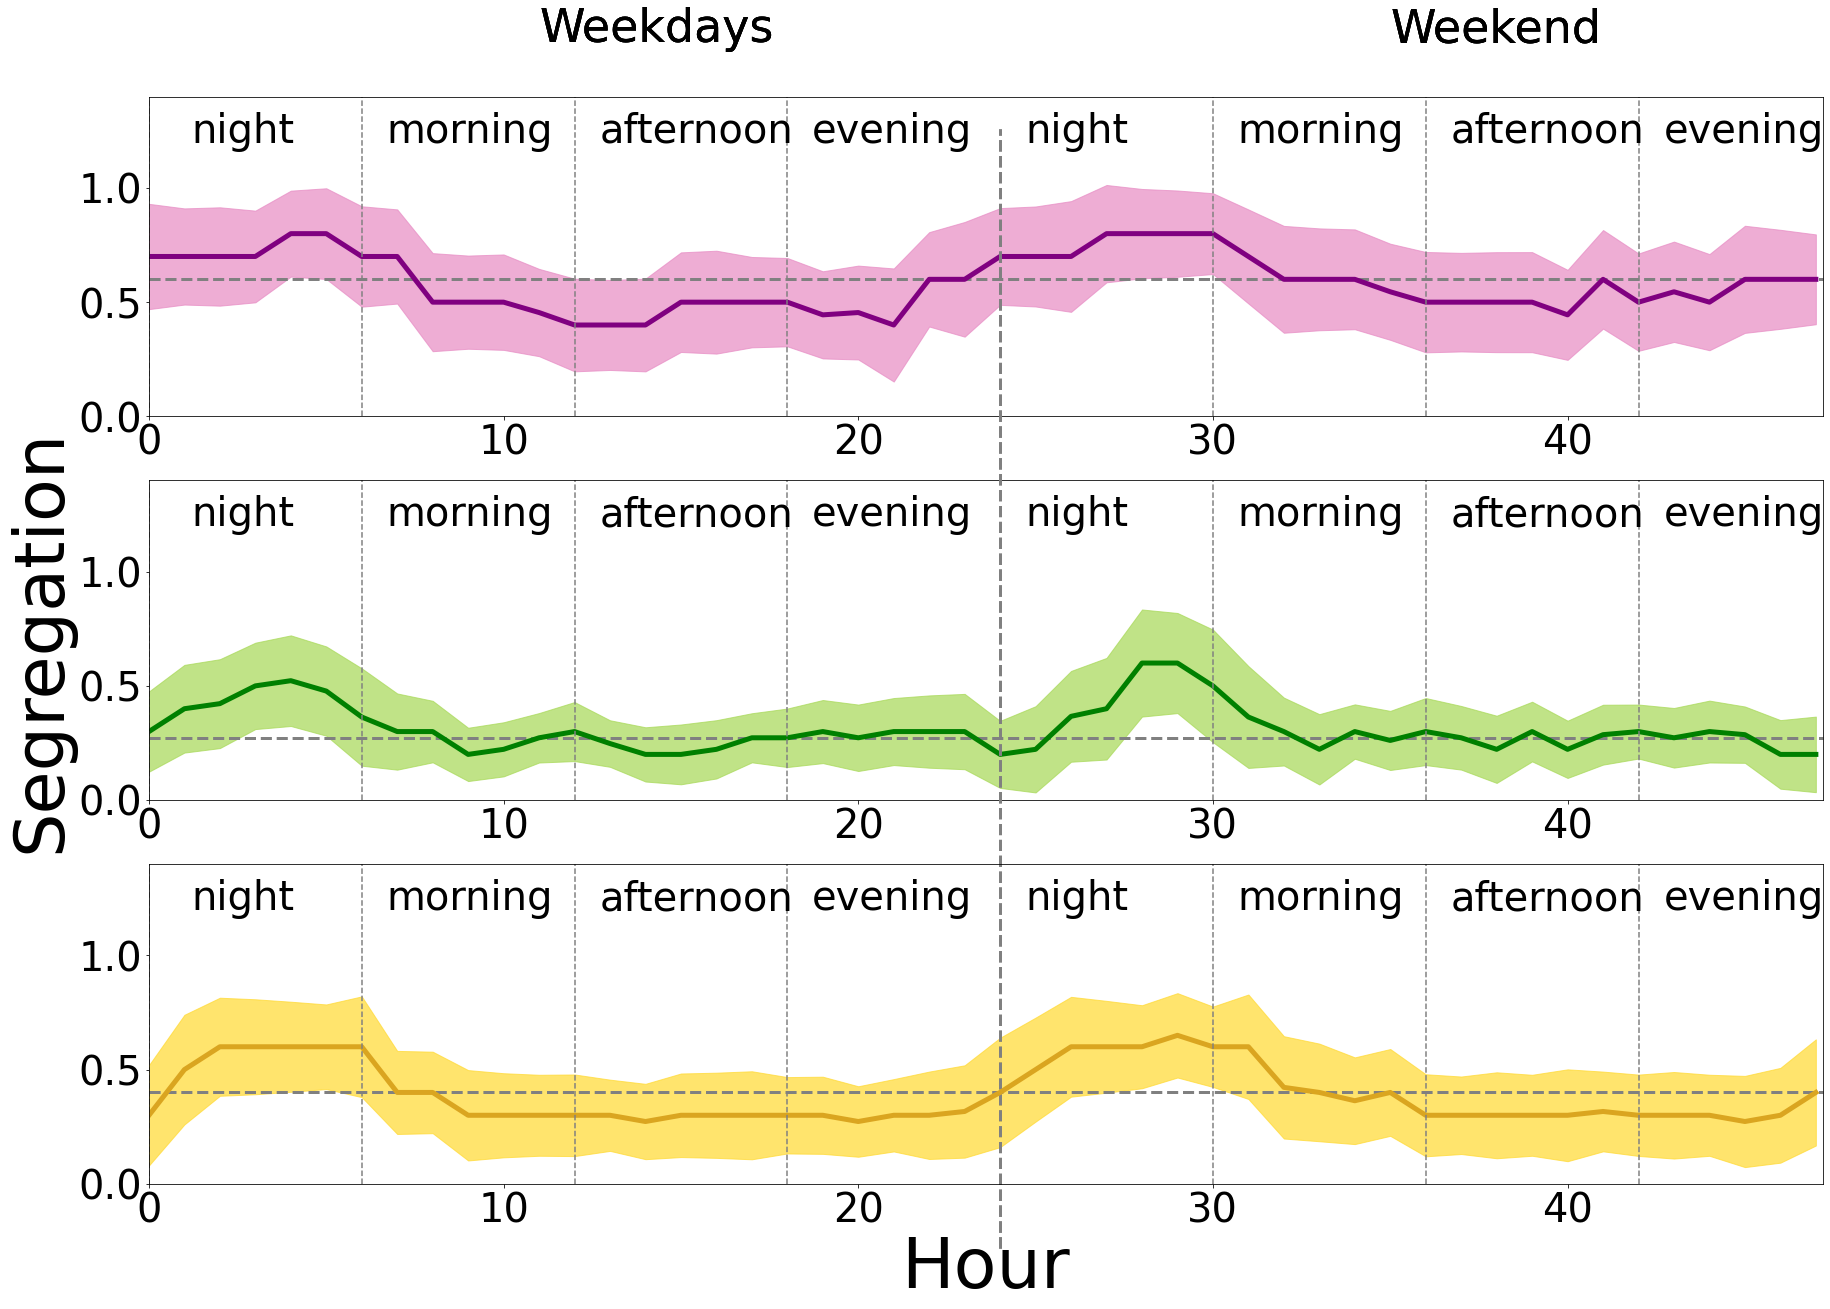

In [5]:
MEDIANS = []

fig, ax = plt.subplots(len(ala_segregation.groupby('cluster')), figsize=(30,20))
color_land=palette
for e, (i, d) in enumerate(ala_segregation.groupby('cluster')):



    d[np.arange(0, 48)].quantile(0.5).plot(ax=ax[e], color =palette_dark[i], lw=5)
        
    
    days=[2.5,8,14,20,26,32,38,44]
    
    axvlines(ax=ax[e], xs=[0,6,12,18,30,36,42], c='grey', ls='--',zorder=2)

    m = d[np.arange(0, 48)].median()
    std = d[np.arange(0, 48)].std()
    xs = range(0,m.shape[0])
    ax[e].fill_between(xs,m+std,m-std,color = color_land[i],alpha = 0.7)


    ax[2].axvline(x=24,c='grey', ls='--' ,ymin=-0.2,ymax=3.3,linewidth=3,zorder=1, clip_on=False)
    ax[e].axhline(y=d['median'].median(),c='grey', ls='--',linewidth=3,zorder=1, clip_on=False)
    ax[e].set_ylim([0,1.4])
    ax[e].set_xlim([0, 47.2])

    day_part=['night','morning','afternoon','evening','night','morning','afternoon','evening']

    for j, txt in enumerate(day_part):

        ax[e].annotate(txt,(days[j]-1.3, 1.2),size=40)

    ax[0].text(11,1.64,'Weekdays',size=46)
    ax[0].text(11+24,1.64,'Weekend',size=46)



    ax[e].get_yaxis().set_visible(True)
    ax[e].tick_params(axis='both', which='major', labelsize=40)



plt.xlabel('Hour',size=70)
ax[1].set_ylabel('Segregation',size=70)


## Fig 3.C

Text(0.5, 0, 'Hour')

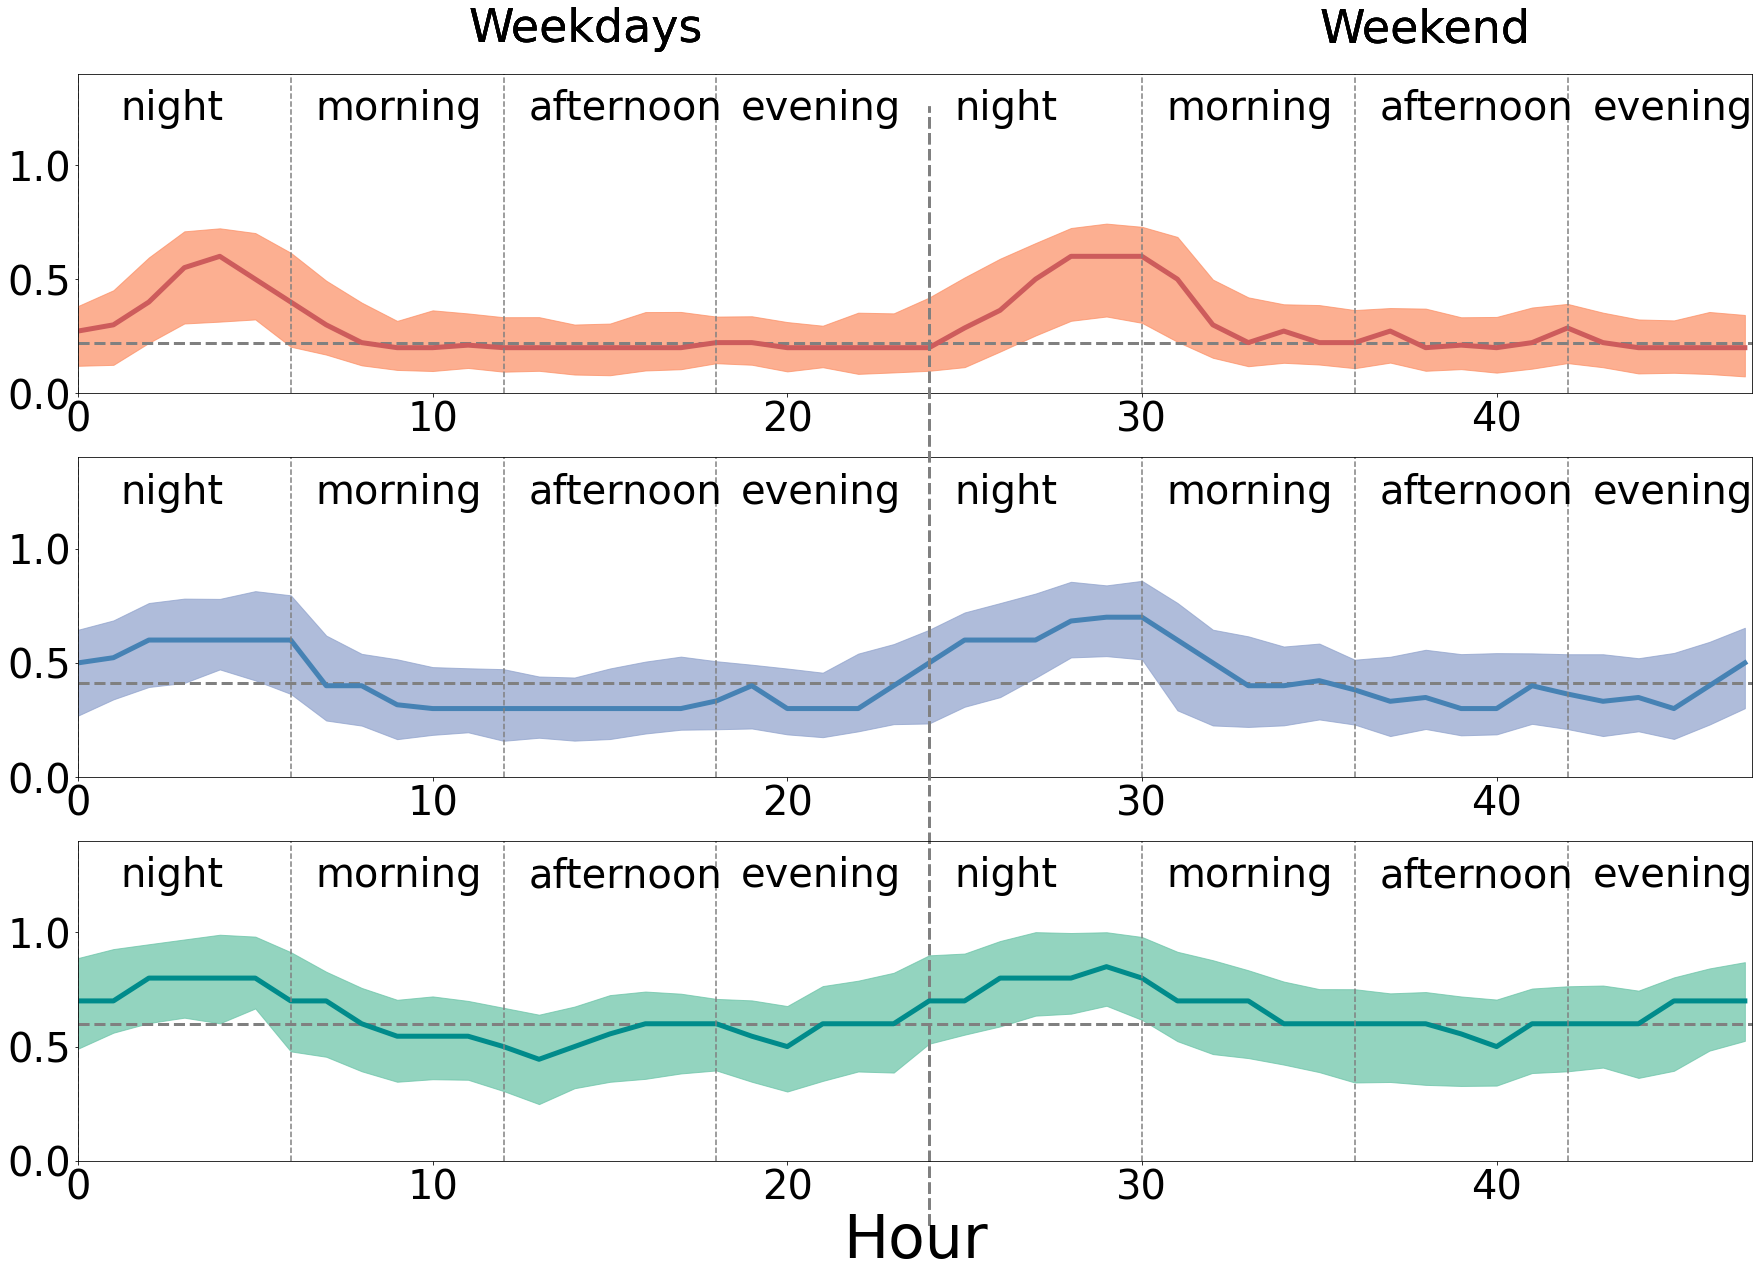

In [6]:
MEDIANS = []

fig, ax = plt.subplots(len(clustered_segregation.groupby('cluster')), 1, figsize=(30,20))

for e, (i, d) in enumerate(clustered_segregation.groupby('cluster')):


    d[np.arange(0, 48)].quantile(0.5).plot(ax=ax[e], color =palette_seg_dark[i], lw=5)

    
    days=[2.5,8,14,20,26,32,38,44]
    
    axvlines(ax=ax[e], xs=[0,6,12,18,30,36,42], c='grey', ls='--',zorder=2)

    m = d[np.arange(0, 48)].mean()
    std = d[np.arange(0, 48)].std()
    xs = range(0,m.shape[0])
    ax[e].fill_between(xs,m+std,m-std,color = palette_seg[i],alpha = 0.7)


    ax[2].axvline(x=24,c='grey', ls='--' ,ymin=-0.2,ymax=3.3,linewidth=3,zorder=1, clip_on=False)
    ax[e].axhline(y=d['median'].median(),c='grey', ls='--',linewidth=3,zorder=1, clip_on=False)
    ax[e].set_ylim([0,1.4])
    ax[e].set_xlim([0, 47.2])

    day_part=['night','morning','afternoon','evening','night','morning','afternoon','evening']

    for j, txt in enumerate(day_part):

        ax[e].annotate(txt,(days[j]-1.3, 1.2),size=40)

    ax[0].text(11,1.54,'Weekdays',size=46)
    ax[0].text(11+24,1.54,'Weekend',size=46)

    ax[e].get_yaxis().set_visible(True)
    ax[e].tick_params(axis='both', which='major', labelsize=40)

plt.xlabel("Hour",size=60)


In [7]:
# Merge the datasets
ala_cluster_segregation = pd.merge(feature_data, clustered_segregation.rename(columns={"cluster":'cluster_seg'})[['grid_id','cluster_seg']])

# Define the features of interest
features = [
    'schools', 'arc_her', 'median_rating', 'median_price', 'entropy_price',
    'entropy_cat', 'entropy_super', 'n_super', 'v_score', 'fitness'
]

def process_cluster_data(cluster_data, cluster_id, features):
    """
    Process the data for a specific cluster.

    :param cluster_data: DataFrame containing the data for the cluster.
    :param cluster_id: ID of the cluster being processed.
    :param features: List of features to process.
    :return: DataFrame containing processed data.
    """
    # Create an empty DataFrame for the results
    result_data = pd.DataFrame()

    for feature in features:
        # Extract the data for the current feature
        feature_data = cluster_data[feature]

        # Create a new DataFrame for this feature
        new_data = pd.DataFrame({
            'value': feature_data,
            'feature': feature,
            'type': 'data',  # This can be adjusted based on your needs
            'cluster': f'cluster {cluster_id}'
        })

        # Append this data to the results DataFrame
        result_data = pd.concat([result_data,new_data],ignore_index=True)

    return result_data

# Process each cluster and combine the results
feature_cluster_segregation = pd.DataFrame()

for cluster_id in range(3):  # Assuming there are 3 clusters (0, 1, 2)
    # Filter the data for the current cluster
    cluster_data = ala_cluster_segregation.query(f"cluster_seg=={cluster_id}")

    # Process the data for this cluster
    processed_data = process_cluster_data(cluster_data, cluster_id, features)

    # Append this data to the combined DataFrame
    feature_cluster_segregation= pd.concat([feature_cluster_segregation,processed_data],ignore_index=True)


## Fig 3.B

In [8]:
# Rename clusters in the DataFrame
ala_cluster_segregation['cluster'] = ala_cluster_segregation['cluster'].replace({
    2: 'Low ALA',
    1: 'Medium ALA',
    0: 'High ALA'
})

ala_cluster_segregation['cluster_seg'] = ala_cluster_segregation['cluster_seg'].replace({
    2: 'Inclusive',
    1: 'Mixed',
    0: 'Segregated'
})


<AxesSubplot:>

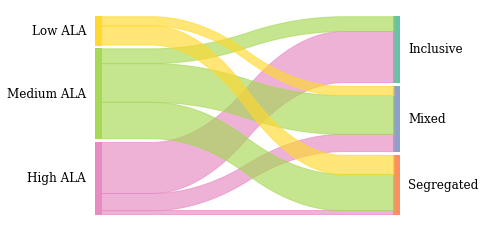

In [9]:
# Define the color dictionary
color_dict = {
    'Low ALA': palette[2],
    'Medium ALA': palette[1],
    'High ALA': palette[0],
    'Inclusive': palette_seg[2],
    'Mixed': palette_seg[1],
    'Segregated': palette_seg[0]
}

# Plot the sankey diagram
sankey(
    ala_cluster_segregation['cluster'], ala_cluster_segregation['cluster_seg'], aspect=20,
    fontsize=12,
    leftLabels=['High ALA', 'Medium ALA', 'Low ALA'],
    rightLabels=['Segregated', 'Mixed', 'Inclusive'],
    colorDict=color_dict
)


## Fig 3.E - only boxplot

In [10]:
VARIABLES_=['Schools',"Architectural \n Heritage  ",'Rating','Price',\
            "Price's \n diversity","Category's \n diversity",'Supermarket \n diversity',\
            'Supermarkets','Velocity \n score','Fitness']

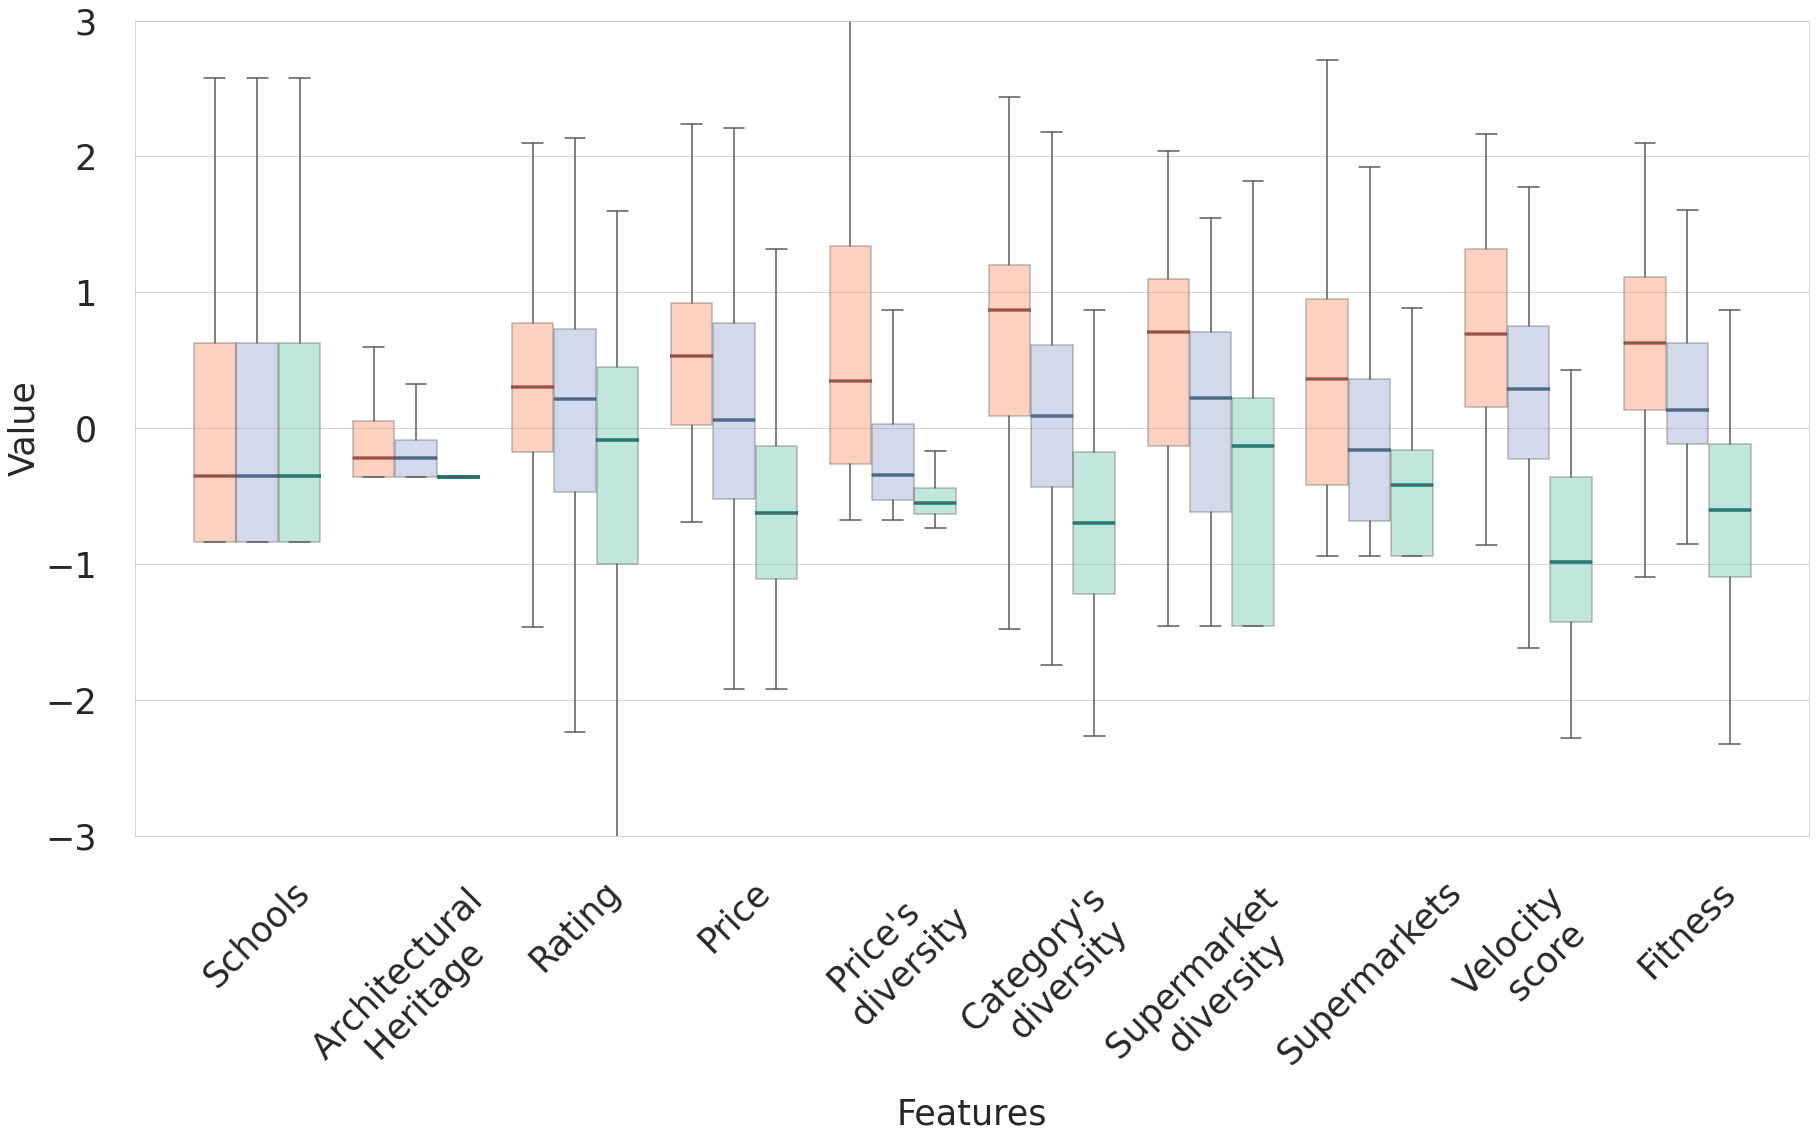

In [11]:
dodge_width = 0.8


sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(30, 15))


boxprops = dict(alpha=0.4)  # rendi le scatole trasparenti
sns.boxplot(x="feature", y="value", data=feature_cluster_segregation, hue='cluster', ax=ax, palette=palette_seg, saturation=1, fliersize=0, boxprops=boxprops)

features = feature_cluster_segregation['feature'].unique()
clusters = feature_cluster_segregation['cluster'].unique()
n_clusters = len(clusters)

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        color = palette_seg_dark[j]
        mean_val = feature_cluster_segregation[(feature_cluster_segregation['feature'] == feature) & (feature_cluster_segregation['cluster'] == cluster)]['value'].median()
        
        position = i + (j - n_clusters/2 + 0.5) * dodge_width/n_clusters
        ax.hlines(mean_val, xmin=position - dodge_width/(2*n_clusters), xmax=position + dodge_width/(2*n_clusters), colors=color, lw=4, linestyles='solid',zorder=0)



ax.set_ylim(-3, 3)
ax.tick_params(axis='both', which='major', labelsize=35, size=35)
ax.tick_params(axis='both', which='minor', labelsize=35, size=35)
ax.set_ylabel("Value", size=35)

ax.set_xlabel("Features", size=35)
ax.set_xticklabels(VARIABLES_, rotation=45)
ax.get_legend().remove()
# Salva il grafico
plt.show()


## Maps layers for Fig 3.D

In [12]:
afternoon_data=gpd.GeoDataFrame(pd.merge(pd.read_csv("/home/lavinia/dottorato/github/afternoon_data.csv"),feature_data))

In [13]:
street=gpd.read_file("/home/lavinia/dottorato/github/street.geojson")
street.to_crs("EPSG:3395")

,highway,geometry
0,primary,"LINESTRING (1010405.229 5668125.461, 1010189.6..."
1,tertiary,"LINESTRING (1010405.229 5668125.461, 1010347.7..."
2,primary,"LINESTRING (1011196.577 5667710.903, 1011179.9..."
3,primary,"LINESTRING (1010189.614 5668171.626, 1010142.2..."
4,tertiary,"LINESTRING (1010189.614 5668171.626, 1010204.7..."
...,...,...
6287,tertiary,"LINESTRING (1014108.116 5670776.608, 1014096.8..."
6288,tertiary,"LINESTRING (1014108.505 5670721.896, 1014105.0..."
6289,primary,"LINESTRING (1014080.353 5670732.519, 1014076.9..."
6290,primary,"LINESTRING (1014108.505 5670721.896, 1014104.1..."


/tmp/ipykernel_17820/1085749490.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbr = fig.colorbar(sm, cax=cax,)


<AxesSubplot:>

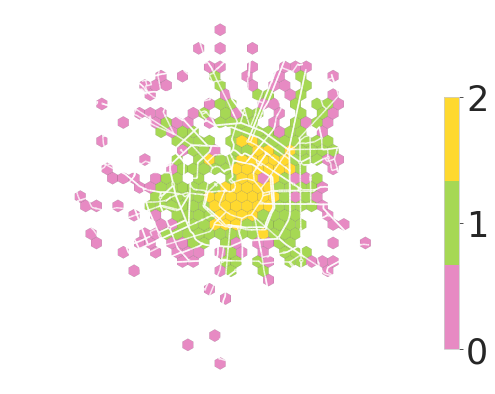

In [14]:
fig, ax = plt.subplots(figsize = (7,7))

feature_data.to_crs("EPSG:3395").plot(column='cluster',legend=False,cmap=my_cmap,ax=ax,vmin=0,vmax=3,edgecolor='black', linewidth=0.08)
plt.axis('off')
cax = fig.add_axes([1, 0.2, 0.03, 0.5])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=35) 
street.to_crs("EPSG:3395").plot(ax=ax,zorder=1,alpha=0.8,color='white')

/tmp/ipykernel_17820/847521953.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbr = fig.colorbar(sm, cax=cax, ticks=[afternoon_data['x'].min(), afternoon_data['x'].max()])


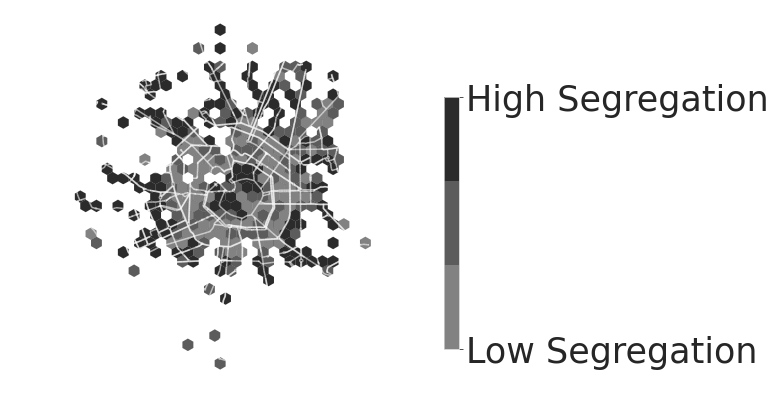

In [15]:
grey_dark = ListedColormap([
    (0.5085736255286428, 0.5085736255286428, 0.5085736255286428),
    (0.35912341407151094, 0.35912341407151094, 0.35912341407151094),
    (0.1679354094579008, 0.1679354094579008, 0.1679354094579008)
])

# Define normalization bounds for three intervals
bounds = [afternoon_data['x'].min(), 
          afternoon_data['x'].quantile(0.33), 
          afternoon_data['x'].quantile(0.67), 
          afternoon_data['x'].max()]
norm_dark = BoundaryNorm(bounds, grey_dark.N)

# Plotting
fig, ax = plt.subplots(figsize=(7,7))
afternoon_data.to_crs("EPSG:3395").plot(column='x', legend=False, cmap=grey_dark, norm=norm_dark, ax=ax, edgecolor='black', linewidth=0.08)
street.plot(ax=ax, zorder=1, alpha=0.6, color='white')

# Remove the axes
plt.axis('off')

# Add a colorbar
cax = fig.add_axes([1, 0.2, 0.03, 0.5])
sm = plt.cm.ScalarMappable(cmap=grey_dark, norm=norm_dark)
sm._A = []  # This line is needed for the colorbar
cbr = fig.colorbar(sm, cax=cax, ticks=[afternoon_data['x'].min(), afternoon_data['x'].max()])
cbr.ax.set_yticklabels(['Low Segregation', 'High Segregation'])  # set the labels
cbr.ax.tick_params(labelsize=35) 

# Display the plot
plt.show()



In [16]:
clustered_segregation=gpd.GeoDataFrame(pd.merge(clustered_segregation,feature_data[['grid_id','geometry']]))

/tmp/ipykernel_17820/4204081082.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbr = fig.colorbar(sm, cax=cax,)


<AxesSubplot:>

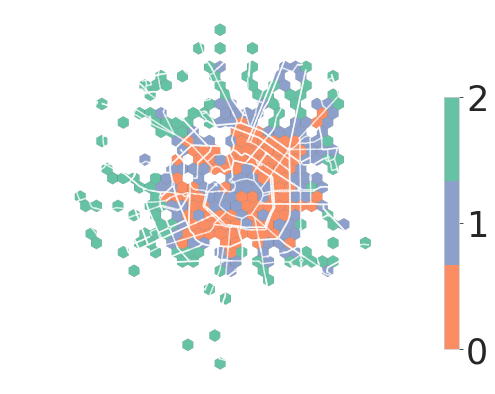

In [17]:
fig, ax = plt.subplots(figsize = (7,7))

clustered_segregation.to_crs("EPSG:3395").plot(column='cluster',legend=False,cmap=my_cmap_seg,ax=ax,vmin=0,vmax=3,edgecolor='black', linewidth=0.08)
plt.axis('off')
cax = fig.add_axes([1, 0.2, 0.03, 0.5])
sm = plt.cm.ScalarMappable(cmap=my_cmap_seg, norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=35) 
street.to_crs("EPSG:3395").plot(ax=ax,zorder=1,alpha=0.8,color='white')